In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import torch
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),         # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize with ImageNet stats
])

In [5]:
data_dir = '/kaggle/input/tyre-quality-classification/Digital images of defective and good condition tyres/'

dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)

In [6]:
dataset.classes

['defective', 'good']

In [7]:
import pandas as pd
class_names = dataset.classes


labels = pd.Series(dataset.targets)


label_counts = labels.value_counts().sort_index()

# 4. Print the results
print("Image counts per class:")
for class_index, count in label_counts.items():
    print(f"-> {class_names[class_index]}: {count} images")

Image counts per class:
-> defective: 1028 images
-> good: 828 images


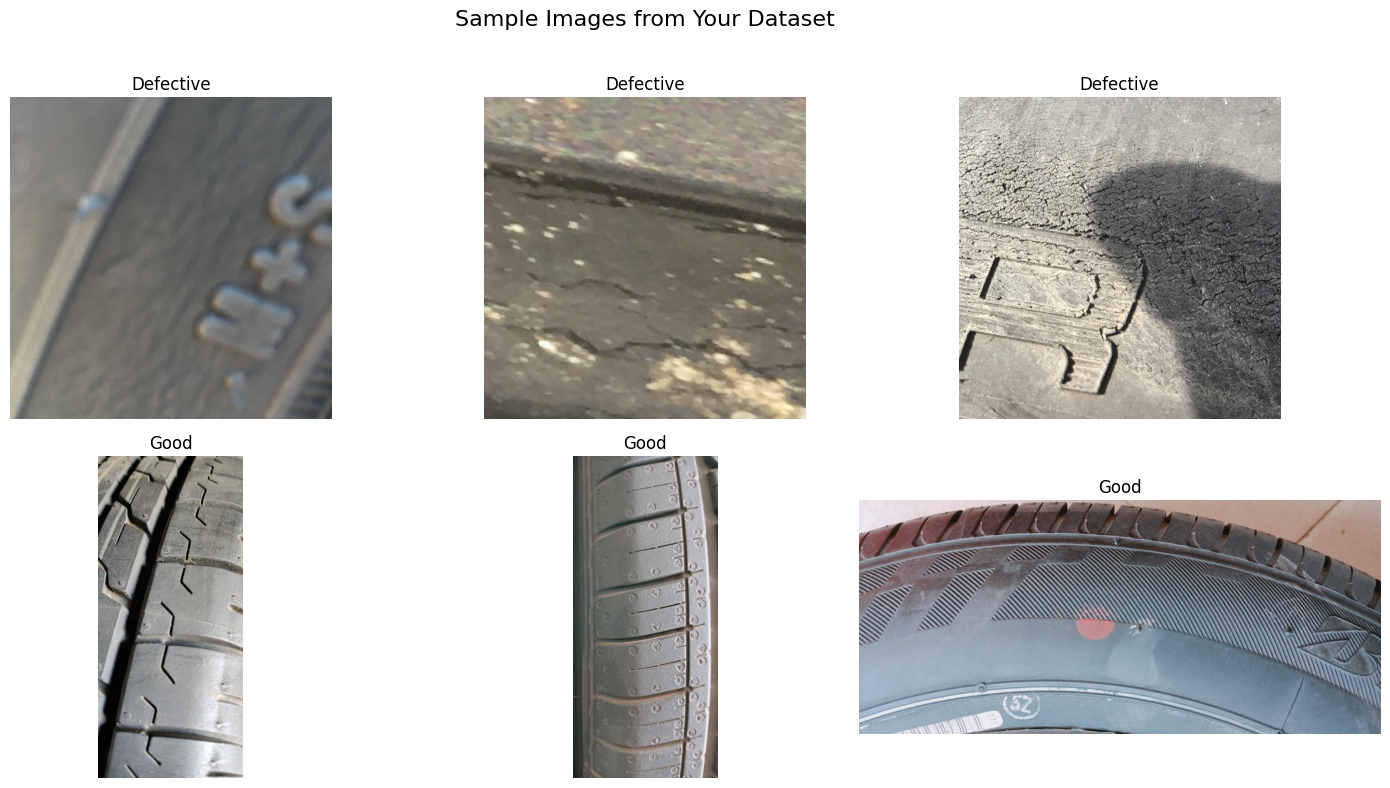

In [8]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# 1. Define the base directory for your data
base_dir = '/kaggle/input/tyre-quality-classification/Digital images of defective and good condition tyres/'

# 2. Create paths for the defective and good folders
defective_dir = os.path.join(base_dir, 'defective')
good_dir = os.path.join(base_dir, 'good')

# 3. Get a few sample image filenames from each folder
# os.listdir() gets all files in a directory
defective_samples = [os.path.join(defective_dir, fname) for fname in os.listdir(defective_dir)[:3]]
good_samples = [os.path.join(good_dir, fname) for fname in os.listdir(good_dir)[:3]]

# 4. Create a figure to display the images
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Sample Images from Your Dataset', fontsize=16)

# Plot defective images
for ax, img_path in zip(axes[0], defective_samples):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title('Defective')
    ax.axis('off')

# Plot good images
for ax, img_path in zip(axes[1], good_samples):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title('Good')
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [9]:
train_ds, val_ds = random_split(dataset, [0.8,0.2])

In [10]:
train_data_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
test_data_loader = DataLoader(val_ds, batch_size=4, shuffle=False)

In [11]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        # Convolutional Block 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Convolutional Block 2
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Flatten the output from conv layers
        self.flatten = nn.Flatten()
        
        # Fully Connected Layers
        # The input features depend on the output size of the last pooling layer
        # For a 128x128 input image: 128 -> 64 (pool1) -> 32 (pool2).
        # So, the size is 32 * 32 * 32 (channels from conv2)
        self.fc1 = nn.Linear(32 * 32 * 32, 512)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model and move it to the device
model = SimpleCNN(num_classes=len(class_names)).to(device)
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [12]:
# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs to train for
NUM_EPOCHS = 5

# Training loop
for epoch in range(NUM_EPOCHS):
    # --- Training Phase ---
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for inputs, labels in train_data_loader:
        # Move inputs and labels to the correct device
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_ds)

    # --- Validation Phase ---
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_preds = 0
    with torch.no_grad(): # No need to calculate gradients during validation
        for inputs, labels in test_data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
            # Get predictions
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels.data)

    val_epoch_loss = val_loss / len(val_ds)
    val_accuracy = correct_preds.double() / len(val_ds)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
          f"Train Loss: {epoch_loss:.4f} | "
          f"Val Loss: {val_epoch_loss:.4f} | "
          f"Val Accuracy: {val_accuracy:.4f}")

print("\nFinished Training!")

Epoch 1/5 | Train Loss: 0.7100 | Val Loss: 0.6283 | Val Accuracy: 0.6388
Epoch 2/5 | Train Loss: 0.5345 | Val Loss: 0.5810 | Val Accuracy: 0.6981
Epoch 3/5 | Train Loss: 0.4313 | Val Loss: 0.5746 | Val Accuracy: 0.7385
Epoch 4/5 | Train Loss: 0.3024 | Val Loss: 0.7446 | Val Accuracy: 0.6954
Epoch 5/5 | Train Loss: 0.2126 | Val Loss: 1.2756 | Val Accuracy: 0.6496

Finished Training!
